In [64]:
# Data Visualization
import matplotlib.pyplot as plt

# Data Manipulation
import numpy as np
import pandas as pd

# Word2Vec Loading
import gensim.downloader as api
from gensim.models import KeyedVectors

# Trie for fast lookup
from datrie import BaseTrie
import string

# Dimensionality Reduction
from umap import UMAP
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

import os

import seaborn as sns

In [4]:
# Import Google News 300 Word2Vec dataset
w2v_model: KeyedVectors = api.load('word2vec-google-news-300')

In [5]:
# Make a Trie for O(1) lookup of containment of words
t = BaseTrie(string.ascii_lowercase)

for x in w2v_model.index_to_key:
    t[x] = True

In [6]:
# Define a helper function to get the vector of a given word
def vec(str):
    return w2v_model.vectors[w2v_model.key_to_index[str]]

In [7]:
LEN_DATA = 50

list_dirnames = []
list_data = []
for subdir, dirs, files in os.walk('./BATS_3.0'):
    for file in files:
        if file.endswith('.txt'):
            list_dirnames.append(file)
            list_data.append(pd.read_csv(os.path.join(subdir, file), sep='\t', header=None))

# Add pair_id, which uniquely identifies each pair, and relation_id, which identifies the dataset
full_df = pd.concat([ df.assign(pair_id=range(LEN_DATA*i, LEN_DATA*(i+1)), relation_id=i) for i, df in enumerate(list_data) ])

# Remove all but the first result for the second element of each pair
full_df[1] = full_df[1].str.split('/', expand=True)[0]

# Remove all pairs where one of the words are not in the word2vec dataset
full_df = full_df[full_df[0].apply(t.__contains__) & full_df[1].apply(t.__contains__)]

In [8]:
word_pair_vecs = np.vstack(full_df[0].apply(vec)) - np.vstack(full_df[1].apply(vec))

In [97]:
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('dim_reduce', PCA(n_components=2, random_state=42))
])

In [100]:
names = pd.Series(list_dirnames).str.extract(r'\[(.*)\]')[0]
name_to_id = pd.Series(names.index.values, index=names)
relation_ids = name_to_id[['country - capital', 'male - female', 'meronyms - member']]
filter_cond = full_df['relation_id'].isin(relation_ids)

transform_filter = pipe.fit_transform(word_pair_vecs[filter_cond])

In [99]:
transform = pipe.fit_transform(word_pair_vecs)

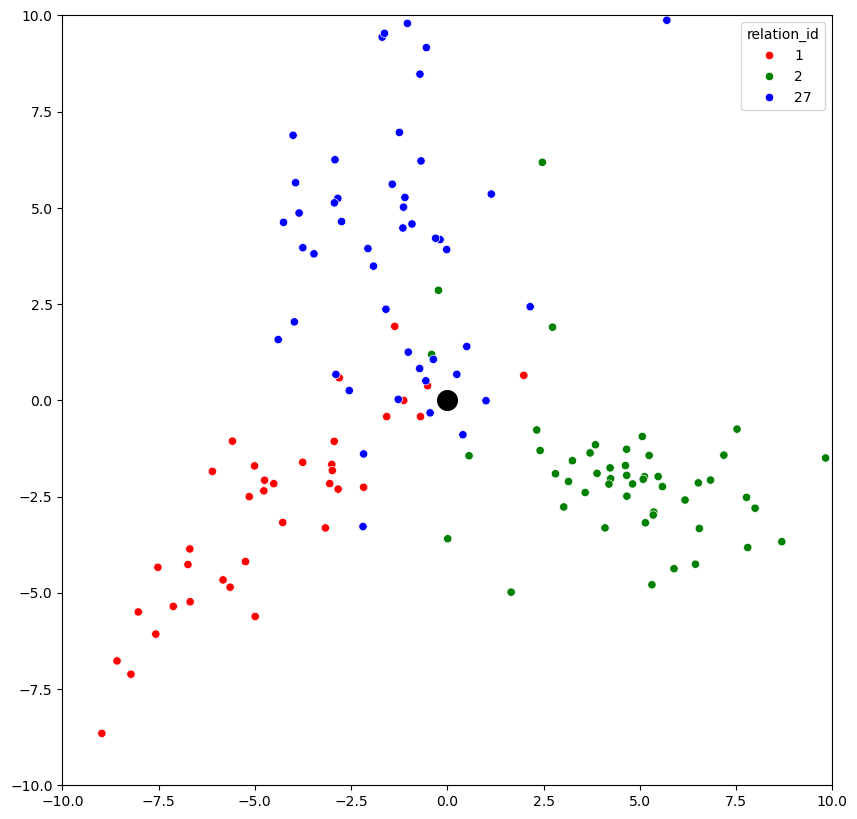

In [116]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim((-10, 10))
plt.ylim((-10, 10))
ax.set_aspect('equal')

sns.scatterplot(x=transform_filter[:, 0], y=transform_filter[:, 1], hue=full_df[filter_cond]['relation_id'], palette=['r', 'g', 'b'])
plt.scatter(0, 0, c='k', s=200);

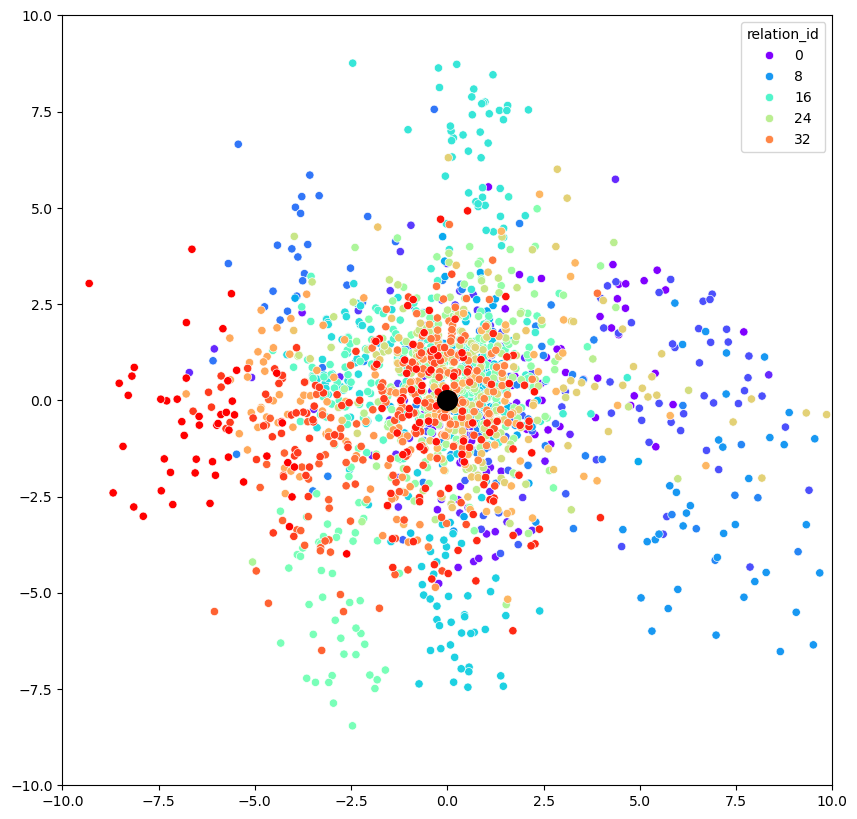

In [115]:
fig, ax = plt.subplots(figsize=(10, 10))
plt.xlim((-10, 10))
plt.ylim((-10, 10))
ax.set_aspect('equal')

sns.scatterplot(x=transform[:, 0], y=transform[:, 1], hue=full_df['relation_id'], palette=plt.cm.rainbow)
plt.scatter(0, 0, c='k', s=200);

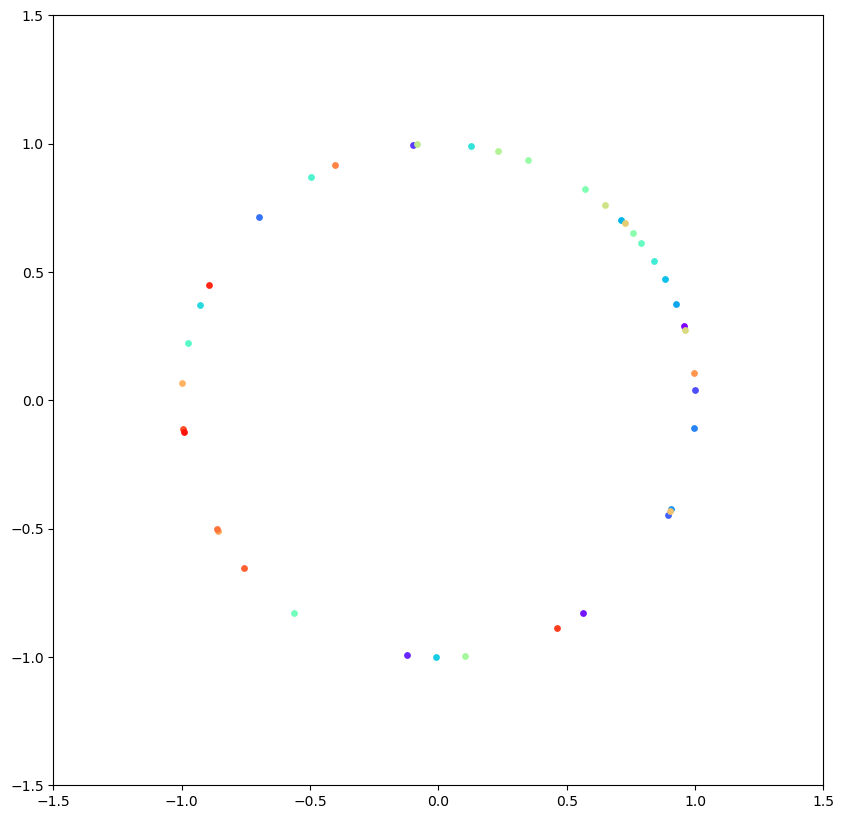

In [90]:
relations = full_df['relation_id'].unique()

fig, ax = plt.subplots(figsize=(10, 10))

# Norm each of the points; this is done because angle matters more than magnitude in Word2Vec
normed_points = transform/np.linalg.norm(transform, axis=1).reshape(-1, 1)

angles = []

for r in relations:
    # Take the average of all the angles
    mean = normed_points[full_df['relation_id'] == r].mean(axis=0)
    # Re-normalize
    normal = mean/np.linalg.norm(mean)

    # Calculate angle
    angle = np.arctan2(*normal)
    angles.append(angle)

    # Calculate color based on relation id, then draw
    color = plt.cm.rainbow(r/len(relations))
    plt.scatter(normal[0], normal[1], color=color, s=15)

plt.xlim((-1.5, 1.5))
plt.ylim((-1.5, 1.5))
ax.set_aspect('equal');

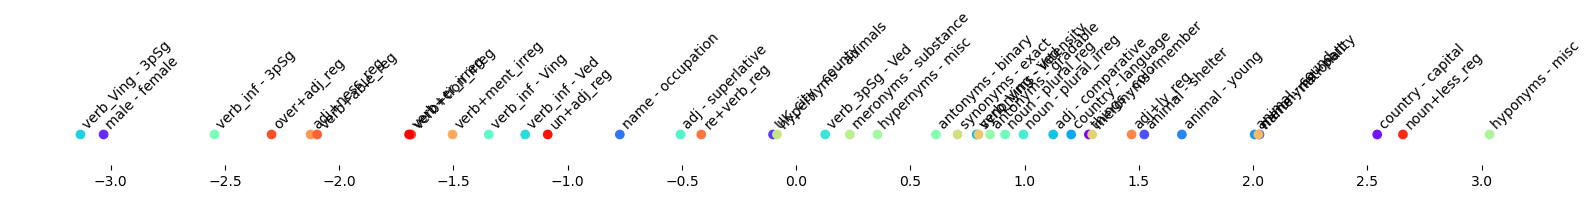

In [39]:
fig, ax = plt.subplots(figsize=(20, 2))

plt.scatter(angles, np.zeros_like(angles), c=np.linspace(0, 1, 40), cmap=plt.cm.rainbow)
plt.yticks([])
plt.ylim((-0.5, 2))
plt.xticks(np.linspace(-3, 3, 13))
plt.box(False)

text = [plt.text(a, 0.1, names[i], rotation=45) for i, a in enumerate(angles)]

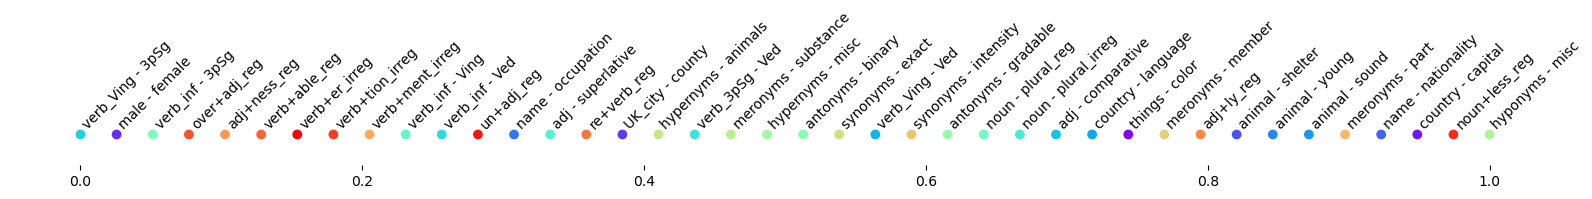

In [117]:
fig, ax = plt.subplots(figsize=(20, 2))

order = np.argsort(angles)
even_points = np.linspace(0, 1, len(order))

plt.scatter(even_points, np.zeros_like(even_points), c=order, cmap=plt.cm.rainbow)
plt.yticks([])
plt.ylim((-0.5, 2))
plt.box(False)

text = [plt.text(x, 0.1, names[i], rotation=45) for i, x in zip(order, even_points)]